In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import netCDF4 as nc
import torch
from torch import nn
from src import load_data, evaluate
import torch.autograd as autograd

In [3]:
USE_CUDA = False
if torch.cuda.is_available():
    print('CUDA Available')
    USE_CUDA = True
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [4]:
data_runoff = load_data.load_discharge_gr4j_vic()

/home/mgauch/runoff-nn/src/load_data.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(dir, f), skiprows=2, skipfooter=1, index_col=False, header=None, names=['runoff'], na_values='-1.2345')
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
# For each station, read which grid cells belong to its subwatershed
station_cell_mapping = pd.read_csv('station_cell_mapping.csv', skiprows=1, names=['station', 'lat', 'lon', 'row', 'col', 'area'])

In [6]:
rdrs_data = load_data.load_rdrs_forcings()

In [37]:
predictions = {}
actuals = {}
seq_len = 3 * 24
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=seq_len // 24 + 1)
train_end = '2013-12-31'
test_start = '2014-01-01'
test_end = '2014-12-31'

for station in data_runoff['station'].unique():
    print(station)
    station_runoff = data_runoff[data_runoff['station'] == station].set_index('date')
    station_cell_ids = 39 * station_cell_mapping[station_cell_mapping['station'] == station]['col'] \
        + station_cell_mapping[station_cell_mapping['station'] == station]['row']
    station_rdrs = rdrs_data.filter(regex='_(' + '|'.join(map(lambda x: str(x), station_cell_ids)) + ')$', axis=1)
    
    if any(station_runoff['runoff'].isna()):
        print('Station', station, 'had NA runoff values. Skipping.')
        continue
    
    station_train = station_rdrs.loc[train_start : train_end]
    station_test = station_rdrs.loc[test_start : test_end]
    num_train_days = len(pd.date_range(train_start, train_end, freq='D'))
    print('  Fitting model')
    
    H = 50
    batch_size = 5
    class LSTMRegression(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, batch_size):
            super(LSTMRegression, self).__init__()
            self.batch_size = batch_size
            self.hidden_dim = hidden_dim
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers)
            self.linear = nn.Linear(hidden_dim, 1)
            self.hidden = self.init_hidden()
        def init_hidden(self):
            return (torch.randn(2, self.batch_size, self.hidden_dim, device=device),
                    torch.randn(2, self.batch_size, self.hidden_dim, device=device))

        def forward(self, input):
            self.hidden = self.init_hidden()
            lstm_out, self.hidden = self.lstm(input, self.hidden)
            return self.linear(lstm_out[-1])
    model = LSTMRegression(station_rdrs.shape[1], H, 2, batch_size)
    
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    x = np.zeros((seq_len, len(pd.date_range(train_start, test_end, freq='D')), station_rdrs.shape[1]))
    for day in range(x.shape[1]):
        x[:,day,:] = station_rdrs[train_start - timedelta(hours = seq_len - 1) + timedelta(days=day) : train_start + timedelta(days=day)]
    x_train = torch.from_numpy(x[:,:num_train_days,:]).float().to(device)
    y_train = torch.from_numpy(station_runoff.loc[train_start:train_end, 'runoff'].to_numpy()).float().to(device)
    
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(3):
        for i in range(num_train_days // batch_size):
            y_pred = model(x_train[:,i*batch_size : (i+1)*batch_size,:])

            loss = loss_fn(y_pred, y_train[i*batch_size : (i+1)*batch_size].reshape((batch_size,1))).to(device)
            print(epoch, i, loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    x_test = torch.from_numpy(x[:,num_train_days:,:]).float().to(device)
    predict = station_runoff[test_start:test_end].copy()
    predict['runoff'] = np.nan
    print('  Predicting')
    for i in range((x.shape[1] - num_train_days) // batch_size):
        predict.loc[:,'runoff'].iloc[i*batch_size : (i+1)*batch_size] = model(x_test[:,i*batch_size : (i+1)*batch_size,:]).detach().numpy().reshape(batch_size)
    
    predictions[station] = predict
    actuals[station] = station_runoff['runoff'].loc[test_start:test_end]
    break

04159492
  Fitting model
0 0 15.55556869506836
1 0 15.493773460388184
  Predicting


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


04159492 	NSE: (clipped to 0) -0.13102585992309268
Median NSE (clipped to 0) -0.13102585992309268 / Min -0.13102585992309268 / Max -0.13102585992309268


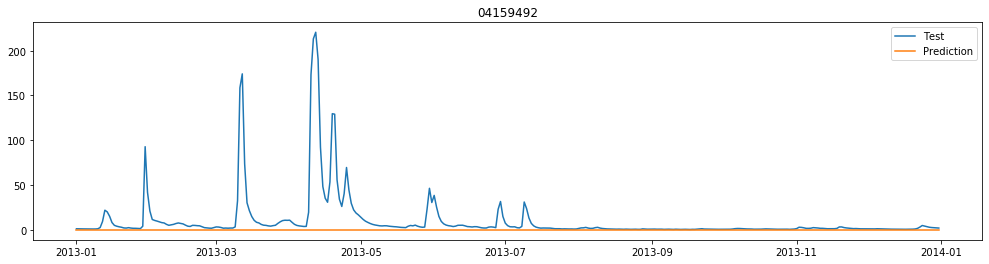

In [40]:
nse_list = []
plot_list = ['04159492', '02GG013']
for station, predict in predictions.items():
    nse = evaluate.evaluate_daily(station, predict['runoff'], actuals[station], plot=station in plot_list)
    nse_list.append(nse)
    
    print(station, '\tNSE: (clipped to 0)', nse_list[-1])

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))

In [38]:
predictions[station]

,runoff,station
date,,
2013-01-01,-0.080967,04159492
2013-01-02,-0.099404,04159492
2013-01-03,-0.070820,04159492
2013-01-04,-0.103428,04159492
2013-01-05,-0.102727,04159492
2013-01-06,-0.124577,04159492
2013-01-07,-0.103533,04159492
2013-01-08,-0.088463,04159492
2013-01-09,-0.081267,04159492


In [39]:
actuals[station]

date
2013-01-01     1.260100
2013-01-02     1.177981
2013-01-03     1.177981
2013-01-04     1.118515
2013-01-05     1.064713
2013-01-06     1.044892
2013-01-07     1.044892
2013-01-08     1.010911
2013-01-09     1.044892
2013-01-10     1.237446
2013-01-11     2.613645
2013-01-12     9.344560
2013-01-13    22.002190
2013-01-14    20.104961
2013-01-15    15.206146
2013-01-16     8.240202
2013-01-17     5.125349
2013-01-18     4.134260
2013-01-19     3.482972
2013-01-20     2.973269
2013-01-21     2.200219
2013-01-22     2.047308
2013-01-23     2.506041
2013-01-24     2.058635
2013-01-25     1.817941
2013-01-26     1.786793
2013-01-27     1.588575
2013-01-28     1.483803
2013-01-29     4.134260
2013-01-30    92.879257
                ...    
2013-12-02     1.206298
2013-12-03     1.192139
2013-12-04     1.138337
2013-12-05     1.296911
2013-12-06     1.203466
2013-12-07     1.127010
2013-12-08     0.993921
2013-12-09     0.923129
2013-12-10     0.877822
2013-12-11     0.835347
2013-12-12 